In [18]:
import gym
import numpy as np

# Define the custom Gym environment for the mass-spring-damper system
class MassSpringDamperEnv(gym.Env):
    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,))

        # Initial state
        self.state = None

    def reset(self):
        # Reset the environment to an initial state
        self.state = np.array([10.0, 0.0])  # Initial position and velocity
        self.current_step = 0
        return self.state

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.current_step += 1

        # Calculate the reward (e.g., minimize position error)
        reward = -abs(position)  # Negative position as the reward (minimize position error)

        # Check if the episode is done
        done = self.current_step >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Create the custom mass-spring-damper environment
env = MassSpringDamperEnv()

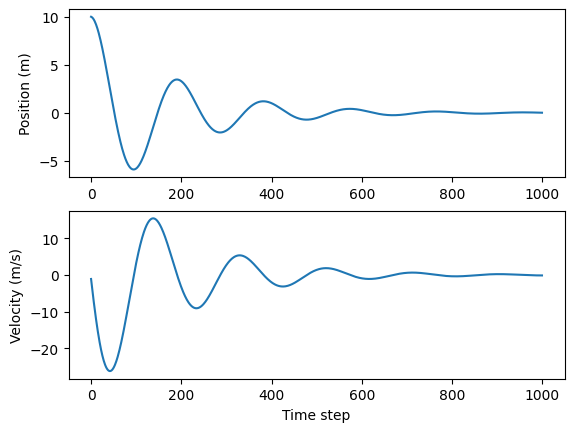

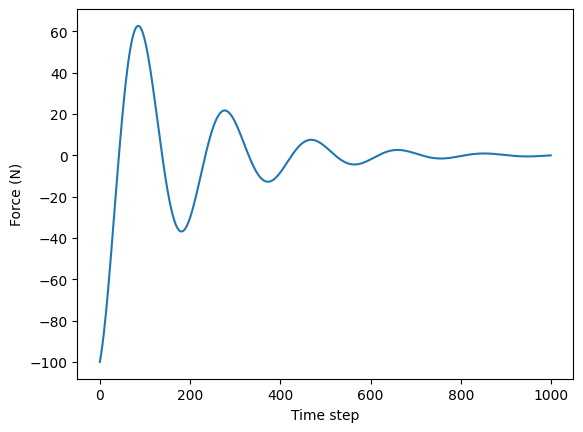

In [19]:
# Proportional controller
def proportional_control(state, target_position):
    position, velocity = state
    error = target_position - position
    force = 10.0 * error - velocity  # Proportional gain
    return force

# Simulate the mass-spring-damper system with the proportional controller
env.reset()
done = False
state_array = []
action_array = []
for _ in range(env.max_steps):
    action = [proportional_control(env.state, 0.0)]
    action_array.append(action)
    state, reward, done, _ = env.step(action)
    state_array.append(state)
    if done:
        break


# Plot the position and velocity of the mass-spring-damper system
import matplotlib.pyplot as plt
state_array = np.array(state_array)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(state_array[:, 0])
plt.ylabel('Position (m)')
plt.subplot(2, 1, 2)
plt.plot(state_array[:, 1])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time step')
plt.show()

# plot action
action_array = np.array(action_array)
plt.figure()
plt.plot(action_array)
plt.ylabel('Force (N)')
plt.xlabel('Time step')
plt.show()



In [20]:
print(state_array)

[[ 9.989      -1.1       ]
 [ 9.9671331  -2.18669   ]
 [ 9.93454289 -3.25902105]
 ...
 [ 0.01602831 -0.13080562]
 [ 0.01471701 -0.13112987]
 [ 0.01340394 -0.13130631]]


In [26]:
import tensorflow as tf
import tensorlayer as tl

W_init = tf.random_normal_initializer(mean=10, stddev=0.3)
b_init = tf.constant_initializer(0.1)

def create_actor_nn(input_state_shape, action_dim, action_range, name=''):
    """
    Build actor network
    :param input_state_shape: state
    :param name: name
    :return: act
    """
    input_layer = tl.layers.Input(input_state_shape, name='A_input')

    layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='A_l1')(input_layer)
    layer = tl.layers.Dense(n_units=64, act=tf.nn.relu, name='A_l2')(layer)
    layer = tl.layers.Dense(n_units=action_dim, act=tf.nn.tanh, name='A_a')(layer)
    layer = tl.layers.Lambda(lambda x: action_range * x)(layer)
    return tl.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)


# Define the actor network
actor = create_actor_nn(input_state_shape=[None, 2], action_dim=1, action_range=100.0, name='actor5')

# Train the actor
actor.train()

# Set the optimizer
train_op = tf.optimizers.Adam(learning_rate=0.001)

# Set the loss function
mse_loss = tf.losses.MeanSquaredError()

# reshape the state and action
state_array = np.array(state_array)
action_array = np.array(action_array)

state_array = np.reshape(state_array, (state_array.shape[0], 2))
action_array = np.reshape(action_array, (action_array.shape[0], 1))

x = tf.convert_to_tensor(state_array, dtype=tf.float32)
y = tf.convert_to_tensor(action_array, dtype=tf.float32)


ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)

In [25]:
actor.compile(optimizer=train_op, loss=mse_loss)
actor.fit(x, y, epochs=100, batch_size=32, verbose=1)

Epoch 1/100


ValueError: in user code:

    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'actor' (type Functional).
    
    Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)
    
    Call arguments received by layer 'actor' (type Functional):
      • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
      • training=True
      • mask=None


In [24]:
# Train the actor
# n_epoch = 1000
# batch_size = 32
# for epoch in range(n_epoch):

#     # Generate a random batch of states and actions
#     indices = np.random.choice(state_array.shape[0], batch_size)
#     x_batch = state_array[indices]
#     y_batch = action_array[indices]

#     x_batch = tf.convert_to_tensor(x_batch, dtype=tf.float32)
#     y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)

#     with tf.GradientTape() as tape:
#         # Predict actions using the actor network
#         action_pred = actor(x_batch)

#         # Compute the loss
#         loss = mse_loss(y_batch, action_pred)



ValueError: Exception encountered when calling layer 'actor' (type Functional).

Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (32, 2)

Call arguments received by layer 'actor' (type Functional):
  • inputs=tf.Tensor(shape=(32, 2), dtype=float32)
  • training=None
  • mask=None

In [10]:
# save actor
actor.save_weights('actor.hdf5')

[TL] [*] Saving TL weights into actor.hdf5
[TL] [*] Saved


In [12]:
%pip install h5py==2.10.0

  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [510 lines of output]
      /Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/setuptools/installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-universal2-cpython-311
      creating build/lib.macosx-10.9-universal2-cpython-311/h5py
      copying h5py/h5py_warnings.py -> build/lib.macosx-10.9-universal2-cpython-311/h5py
      copying h5py/version.py -> build/lib.macosx-10.9-universal2-cpython-311/h5py
      copying h5py/highlevel.py -> build/lib.macosx-10.9-universal2-cpython-311/h5py
      copying h5py/__init__.py -> build/

In [11]:
# load actor
actor.load_weights('actor.hdf5')

AttributeError: 'str' object has no attribute 'decode'

In [8]:
# Simulate the mass-spring-damper system with the trained actor
env.reset()
done = False
state_array = []
action_array = []

for _ in range(env.max_steps):
    state = np.array(env.state)
    action = loaded_network(np.array([state], dtype=np.float32))[0]
    action_array.append(action)
    state, reward, done, _ = env.step(action)
    state_array.append(state)
    if done:
        break


# Plot the position and velocity of the mass-spring-damper system
state_array = np.array(state_array)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(state_array[:, 0])
plt.ylabel('Position (m)')
plt.subplot(2, 1, 2)
plt.plot(state_array[:, 1])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time step')
plt.show()

# plot action
action_array = np.array(action_array)
plt.figure()
plt.plot(action_array)
plt.ylabel('Force (N)')
plt.xlabel('Time step')
plt.show()


NameError: name 'loaded_network' is not defined